## Assignment #3

## Name: Luke Lopez

### Question 13

This question should be answered using the [Weekly](https://rdrr.io/cran/ISLR/man/Weekly.html) data set, which is part of the `ISLR` package. This data is similar in nature to the `Smarket` data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [1]:
# Import standard Python data science libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
sns.set()

# Import classes from scikit-learn for logistic regression, LDA, QDA, and KNN classification
# Import convenience function for computing confusion matrices 
# Import OneHotEncoder and StandardScaler for data pre-processing
# Import Pipeline, ColumnTransformer to encapsulate pre-processing heterogenous data and fitting
# into a single estimator
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would use the StatsModels Formula API
import statsmodels.api as sm
import statsmodels.formula.api as smf

weekly_filepath = "Weekly.csv"
weekly = pd.read_csv(weekly_filepath)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


### (a) Produce some numerical and graphical summaries of the `Weekly` data. Do there appear to be any patterns?

In [2]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [3]:
weekly["Direction"].value_counts()

Up      605
Down    484
Name: Direction, dtype: int64

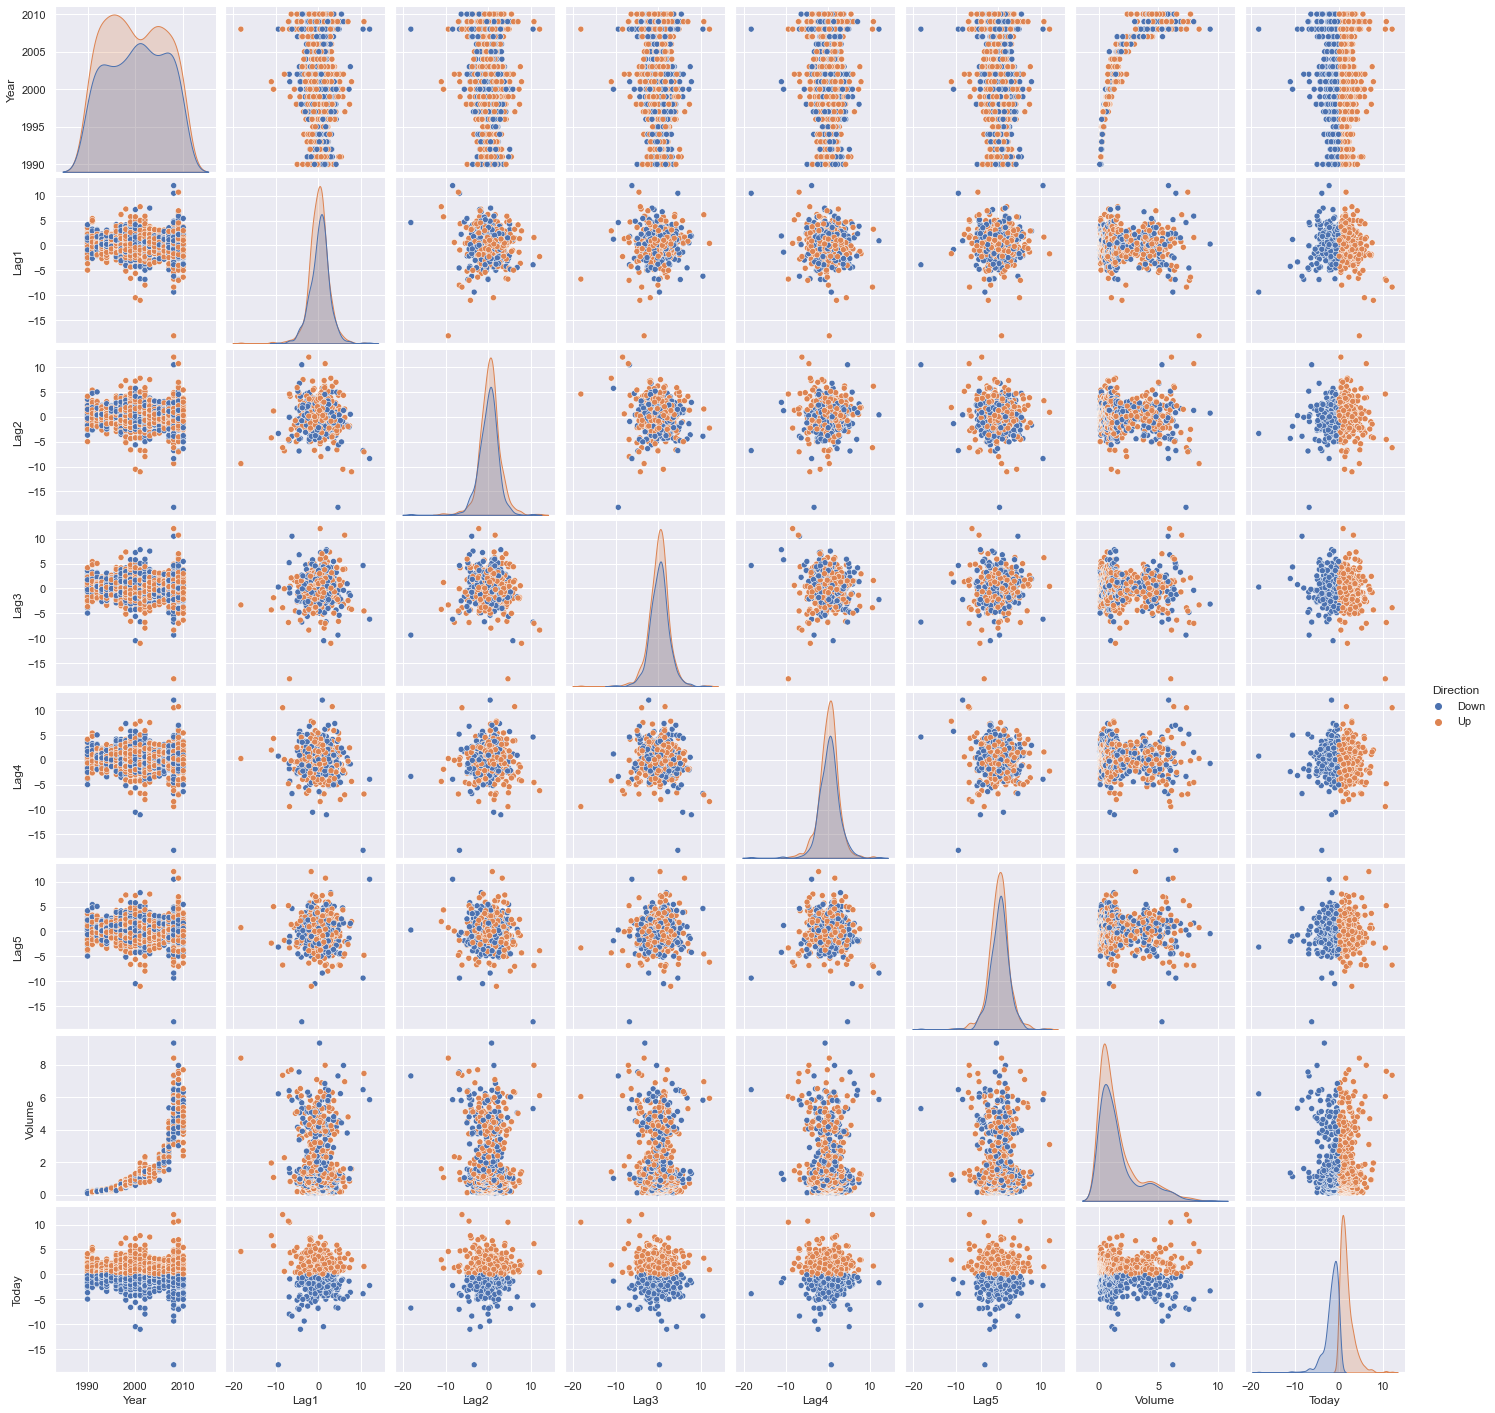

In [4]:
sns.pairplot(weekly, hue = "Direction");

When taking a look at the initial summary statistics and scatterplot matrix, it seems as if no patterns emerge, except for the volume of shares traded per week has increased between 1990 and 2010. When looking at the scatterplot and focusing solely on volume over time reveals an increase in the number of shares traded per week over the 21-year period. 

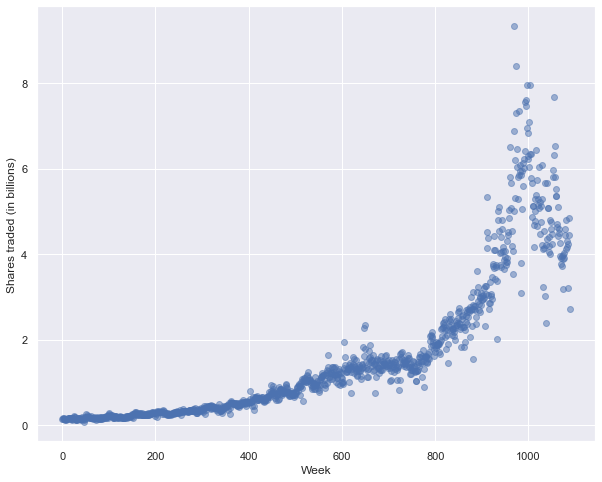

In [5]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x = weekly.index, y = weekly["Volume"], alpha = 0.5)
ax.set(xlabel = "Week", ylabel = "Shares traded (in billions)");

In [6]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Lastly, we look at the matrix of correlations between the variables. Looking at the last row, we can see that each of the lag variables is only correlated very weakly with today's returns. The sole substantial value of 0.842, between Volume and Year, aligns with the strong correlation we saw in the above scatterplot.

###  (b) Use the full data set to perform a logistic regression with `Direction` as the response and the five lag variables plus `Volume` as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [7]:
# Using the Logit class from StatsModels
# First encode response numerically
endog = (weekly["Direction"] == "Up").astype("int64")
exog = sm.add_constant(weekly.drop(columns = ["Direction", "Year", "Today"]))
logit_mod = sm.Logit(endog, exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                0.006580
Time:                        19:11:17   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

The only predictor that stands out as statistically significant is Lag2, having a p-value of 0.030. This suggests evidence to reject the null hypothesis that it's unrelated to the response Direction, favoring an association between Lag2 and Direction. While Lag1 isn't quite significant, it is somewhat close, since it has a significance at the 10% level, with a p-value of 0.118.

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In order to produce a confusion matrix that helps us better visualize the incorrect predictions, we use seaborn to convert the confusion matrix into a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap).

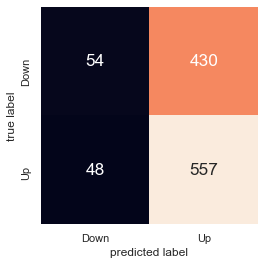

In [8]:
mat = pd.DataFrame(logit_res.pred_table(), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [9]:
logit_preds = pd.Series(logit_res.predict()).apply(lambda x: "Up" if (x > 0.5) else "Down")
(logit_preds == weekly["Direction"]).mean()

0.5610651974288338

Examining the confusion matrix, our logistic regression model using five lag variables plus Volume as predictors achieved an accuracy of 0.5611 on the training data. However, this accuracy is not substantially better than a naive strategy of always predicting up weeks. Focusing on predicting market uptrends, our model shows a high true positive rate (sensitivity) of approximately 0.92 but also a high false positive rate of about 0.888, which may pose risks in financial decision-making. The positive predictive value, at around 0.564, doesn't outperform random guessing. The negative predictive value is approximately 0.529, indicating modest accuracy in predicting market downtrends.

### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with `Lag2` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [10]:
train_mask = (weekly["Year"] < 2009)

In [11]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(weekly.loc[train_mask, "Lag2"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                0.003076
Time:                        19:11:17   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [12]:
#use the model to predict test values
test_exog = sm.add_constant(weekly.loc[~train_mask, "Lag2"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

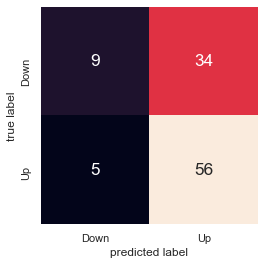

In [13]:
#evaluate the prediction
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [14]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.625

In [15]:
(weekly.loc[~train_mask, "Direction"] == "Up").mean()

0.5865384615384616

After fitting a logistic regression model using only Lag2 as the predictor on data from 1990 through 2008, the model accurately predicted market direction for 62.5% of the weeks in the held-out data from 2009 and 2010. Although this performance surpasses random chance, it represents less than a 10% improvement over simply predicting every week as an up week. Considering an up week as a positive outcome, the model achieved a true positive rate of approximately 0.918 and a false positive rate of about 0.791. The positive predictive value stands at around 0.622, while the negative predictive value is approximately 0.643.

### (e) Repeat (d) using LDA.

In [16]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

In [17]:
# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

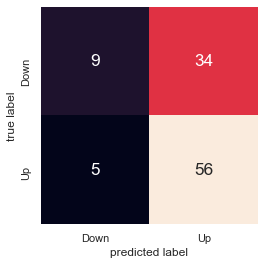

In [18]:
# Make predictions on test data and evaluate the fit
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [19]:
lda_clf.score(X_test, y_test)

0.625

After conducting linear discriminant analysis solely on Lag2 as the predictor using data from 1990 through 2008, we obtained an identical confusion matrix to the one observed in part (d) with the logistic regression model. As seen previously, the model accurately predicted the market direction for 62.5% of the weeks in the held-out data from 2009 and 2010. Although this performance surpasses random chance, it still represents less than a 10% improvement over naively predicting every week as an up week. Continuing with the convention from part (c) regarding an up week as a positive result, the true positive rate stands at approximately 0.918, while the false positive rate is about 0.791. Additionally, the positive predictive value is roughly 0.622, and the negative predictive value is approximately 0.643.

### (f) Repeat (d) using QDA.

In [20]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

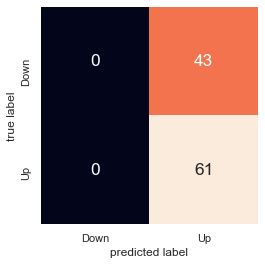

In [21]:
# Make predictions on test data and evaluate the fit
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [22]:
qda_clf.score(X_test, y_test)

0.5865384615384616

After employing quadratic discriminant analysis solely on Lag2 as the predictor using data from 1990 through 2008, the resulting model predicted every week in 2009 and 2010 to be an up week. Consequently, the model achieved a 58.7% accuracy rate in predicting the market direction in the held-out data. While this is better than random chance, it mirrors the outcome one would obtain from simply predicting every week as an up week. Thus, to effectively compare this model's performance with the logistic regression and linear discriminant analysis models, testing on a larger dataset would be necessary. Following the convention from part (c) where an up week is considered a positive result, the true positive rate is 1, while the false positive rate is also 1. Furthermore, the positive predictive value is around 0.587. As there were no negative predictions, discussing the negative predictive value is irrelevant.

### (g) Repeat (d) using KNN with K = 1.

In [23]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

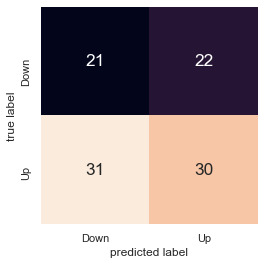

In [24]:
# Make predictions on test data and evaluate the fit
y_pred = knn_1_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [25]:
knn_1_clf.score(X_test, y_test)

0.49038461538461536

After applying k-nearest neighbors classification with k=1 exclusively on Lag2 as the predictor using data from 1990 through 2008, the model correctly predicted the market direction for 49% of the weeks in the held-out data from 2009 and 2010. However, this performance is essentially no better than random guessing and even worse than naively predicting every week as an up week. Following the convention from part (c) where an up week is considered a positive result, the true positive rate is approximately 0.492, while the false positive rate is around 0.512. Additionally, the positive predictive value stands at about 0.577, and the negative predictive value is roughly 0.404.

### (h) Which of these methods appears to provide the best results on this data?

Among the methods tested on the given data, Linear Discriminant Analysis (LDA) and Logistic Regression (Logit) stand out with the highest accuracy scores, both achieving a solid 62.5%. This indicates that these two methods were the most successful in predicting the market direction. Quadratic Discriminant Analysis (QDA) follows closely behind with an accuracy of 58.65%, showing slightly lower performance. However, k-Nearest Neighbors (KNN) trails behind the others with an accuracy of 50%, suggesting it may not be as effective in this particular context. Overall, LDA and Logit demonstrate the most promising performance among the methods tested.

In [26]:
d={'KNN':[knn_1_clf.score(X_test, y_test)],
   'LDA': [lda_clf.score(X_test, y_test)],
   'Logit': [(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()], 
   'QDA': [qda_clf.score(X_test, y_test)]}
df = pd.DataFrame(data=d,index=["Accuracy"]).T.sort_values(by='Accuracy',ascending=False)
df

,Accuracy
LDA,0.625000
Logit,0.625000
QDA,0.586538
KNN,0.490385


### (i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [27]:
weighted_lag_avg = 0.4*weekly["Lag1"] + 0.35*weekly["Lag2"] + 0.15*weekly["Lag3"] + 0.05*weekly["Lag4"] + 0.05*weekly["Lag5"]
weekly["weighted_lag_avg"] = weighted_lag_avg
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,weighted_lag_avg
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0.10055
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0.20515
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,-1.12070
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,0.58290
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1.15560


In [28]:
weekly[["Today", "weighted_lag_avg"]].corr()

,Today,weighted_lag_avg
Today,1.000000,-0.037241
weighted_lag_avg,-0.037241,1.000000


Computing the correlation between this weighted average and the value of the current week's return, we see that there only a very weak correlation between the two quantities. It is smaller in magnitude than the correlations between `Today` and the first the lag variables individually. That seems to suggest that this weighting might not be too useful, but I will still try out each of the classification methods using this transformation of the predictors. I will start out with logistic regression.

In [29]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(weekly.loc[train_mask, "weighted_lag_avg"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.687529
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:               0.0002054
Time:                        19:11:18   Log-Likelihood:                -677.22
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                    0.5978
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2135      0.064      3.312      0.001       0.087       0.340
weighted_lag_avg    -0.0282      0.053     -0.527      0.599      -0.133       0.077
====================================================================================
"""

In [30]:
test_exog = sm.add_constant(weekly.loc[~train_mask, "weighted_lag_avg"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

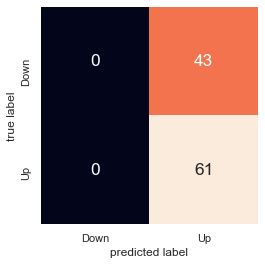

In [31]:
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [32]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.5865384615384616

The outcomes from logistic regression aren't very promising, given that using a prediction threshold of 50% essentially equated to always predicting an up market when assessed on the test set. Moreover, the p-value for the coefficient of 'weighted_lag_avg' stands at 0.599, indicating a lack of statistical significance. Upon reflecting further on the concept of using a weighted average, it becomes evident that logistic regression's performance is unlikely to surpass what was achieved in part (d). This is because the weighted average still constitutes a linear combination of the variables. As we observed earlier, in logistic regression, only 'Lag2' emerged as a statistically significant coefficient, and even then it's borderline at the 5% significance level. Consequently, including the weighted average introduces variables that aren't particularly helpful in constructing a robust model. Despite this, I'll still evaluate the remaining methods using 'weighted_lag_avg' before exploring another combination of predictors. Next in line is linear discriminant analysis.

***

## Question 14

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the `Auto` data set.

In [51]:
auto = pd.read_csv("Auto.csv", na_values = ["?"]).dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [52]:
auto["origin"] = auto["origin"].map({1: "American", 2: "European", 3: "Japanese"})
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino


### (a) Create a binary variable, `mpg_med`, that contains `Above` if `mpg` contains a value above its median, and a `Below` if `mpg` contains a value below its median. You can compute the median using the `Series.median()` function. 

In [53]:
mpg_med = (auto["mpg"] > auto["mpg"].median()).map({False: "Below", True: "Above"})
auto["mpg_med"] = mpg_med
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_med
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu,Below
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320,Below
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite,Below
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst,Below
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino,Below


### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting `mpg_med`? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.

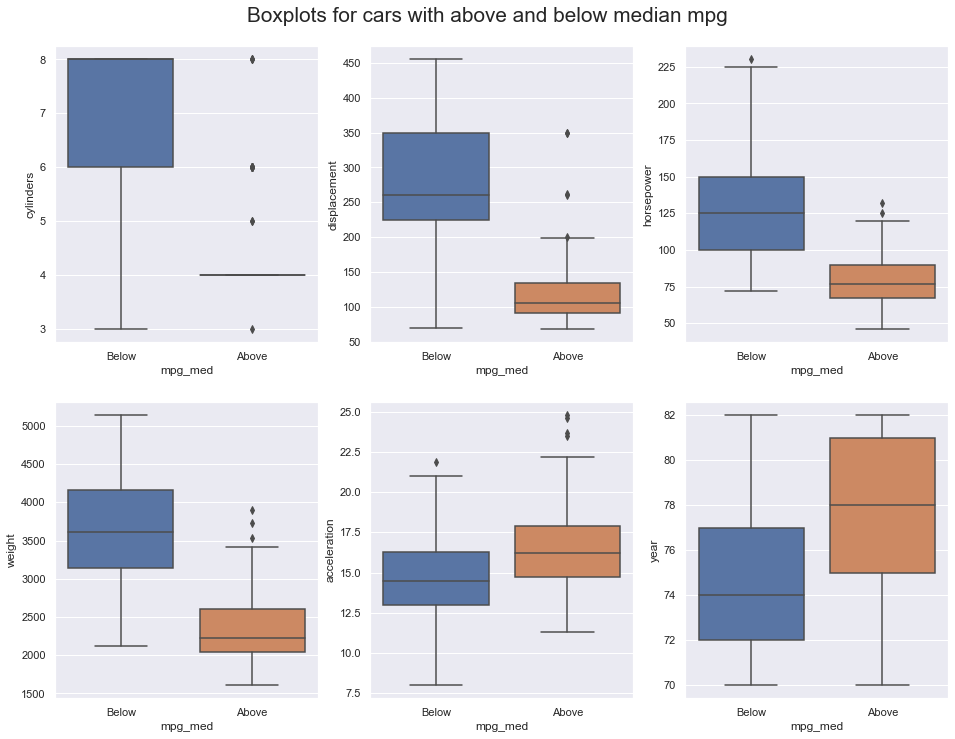

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "mpg_med", y = "cylinders", data = auto, ax = axes[0, 0])
sns.boxplot(x = "mpg_med", y = "displacement", data = auto, ax = axes[0, 1])
sns.boxplot(x = "mpg_med", y = "horsepower", data = auto, ax = axes[0, 2])
sns.boxplot(x = "mpg_med", y = "weight", data = auto, ax = axes[1, 0])
sns.boxplot(x = "mpg_med", y = "acceleration", data = auto, ax = axes[1, 1])
sns.boxplot(x = "mpg_med", y = "year", data = auto, ax = axes[1, 2])
fig.suptitle("Boxplots for cars with above and below median mpg", size = "xx-large", y = 0.925);

To compare the overall distributions of each quantitative variable between cars with above-median and below-median mpg, I created boxplots. Starting in the upper-left corner, we observe that the majority of cars with above-median mpg tend to have four-cylinder engines, although there are some outliers. Moving to the upper-middle pair of boxplots, it's evident that at least 75% of the cars with above-median mpg have smaller engines compared to 75% of the cars with below-median mpg. This trend continues for horsepower (upper-right pair of boxplots) and weight (lower-left pair of boxplots). However, in the final two pairs of boxplots for acceleration and manufacture year, although there are discernible differences between cars with above-median and below-median mpg, these differences aren't as pronounced compared to the first four predictors. Particularly, there's notably more overlap in both time to reach 60 mph and manufacture year between the two categories of cars, whereas for the other predictors, there's minimal overlap in the boxplots between the two categories. This suggests that cylinders, displacement, horsepower, and weight are likely to be the most informative predictors in predicting median mpg.

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

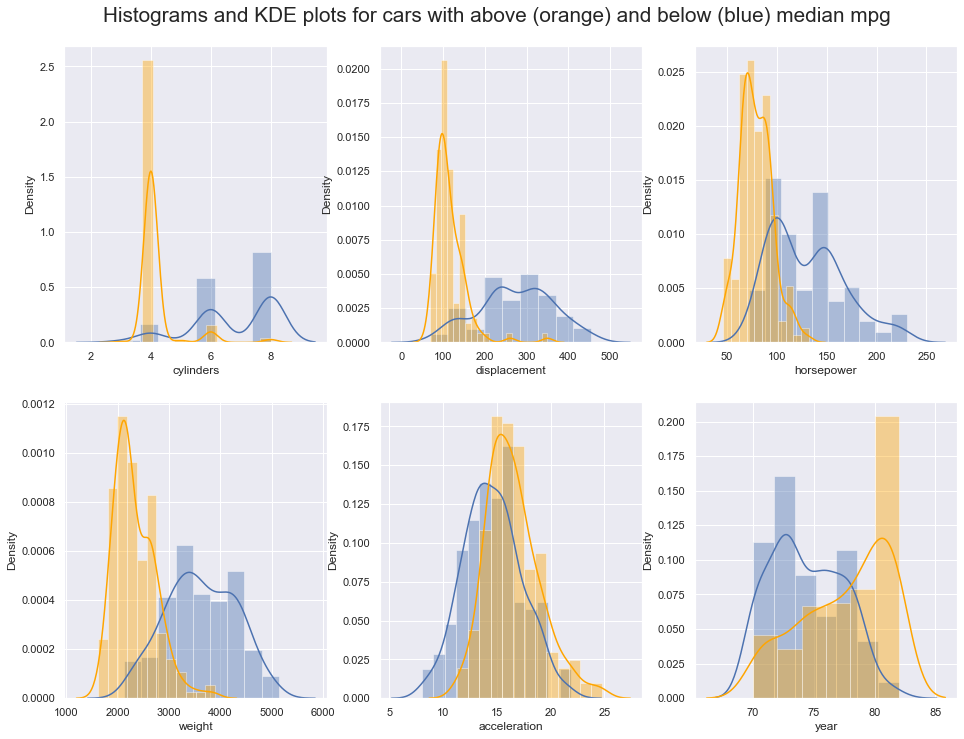

In [55]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "cylinders"], ax = axes[0, 0])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "cylinders"], ax = axes[0, 0], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "displacement"], ax = axes[0, 1])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "displacement"], ax = axes[0, 1], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "horsepower"], ax = axes[0, 2])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "horsepower"], ax = axes[0, 2], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "weight"], ax = axes[1, 0])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "weight"], ax = axes[1, 0], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "acceleration"], ax = axes[1, 1])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "acceleration"], ax = axes[1, 1], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "year"], ax = axes[1, 2])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "year"], ax = axes[1, 2], color = "orange")
fig.suptitle("Histograms and KDE plots for cars with above (orange) and below (blue) median mpg",
             size = "xx-large", y = 0.925);

Looking at histograms overlaid with kernel density estimates we are better able to visualize the extent to which the distributions of the cars with above-median fuel economy overlap with the distributions of the cars with below-median fuel economy for each quantitative variable. This provides further evidence to suggest that horsepower and weight will be useful in predicting mpg_med, with decently clear separations between the distribution peaks between above-median and below-median cars. The plot involving `cylinders` seems to indicate that that variable wouldn't be as helpful on on its own. The small number of possibilities for the number of engine cylinders (3, 4, 5, 6, or 8) results in a lot of overlap, though there is a very prononunced peak that indicates a large number of cars with above-median fuel efficiency have four-cylinder engines. The significant overlap between groups for the acceleration plot is further evidence to suggest that acceleration will not be a variable that is helpful in predicting `mpg_med`.

### (c) Split the data into a training set and a test set.

In [58]:
# a convenient function for splitting data sets
X_train, X_test, y_train, y_test = train_test_split(auto, auto["mpg_med"], test_size = 0.25, random_state = 312)

### (d) Perform LDA on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

In [59]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

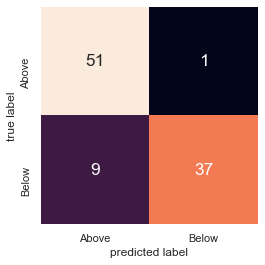

In [60]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [61]:
1 - clf.score(X_test, y_test)

0.10204081632653061

When employing linear discriminant analysis to forecast mpg_med based on cylinders, displacement, horsepower, weight, year, and origin, we encountered an overall test error rate of 10.2%. An interesting observation is that this approach only misclassified one car with above-median fuel economy.

In [62]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

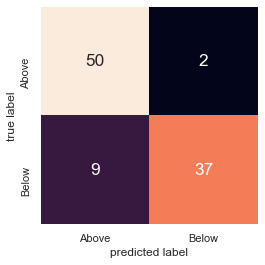

In [63]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [64]:
1 - clf.score(X_test, y_test)

0.11224489795918369

After exluding the origin and year variables, the test error increases to 11.2%.

### (d) Perform QDA on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

In [65]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

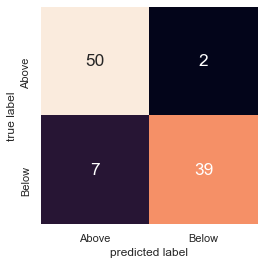

In [66]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [67]:
1 - clf.score(X_test, y_test)

0.09183673469387754

When using quadratic discriminant analysis to predict `mpg_med` using `cylinders`, `displacement`, `horsepower`, `weight`, `year`, and `origin`, we had an overall test error of 9.18%, which is slight decrease compared to linear discriminant analysis using all of those predictors.

In [68]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

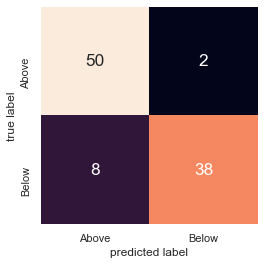

In [69]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [70]:
1 - clf.score(X_test, y_test)

0.10204081632653061

Excluding the origin and year variables, our overall test error slightly increases to 10.2%. Remarkably, this mirrors the performance of linear discriminant analysis using all of the original predictors, although this model exhibits a different confusion matrix. Specifically, employing the convention where above-median mpg is the positive class label, this model demonstrates a lower false positive rate (approximately 0.174 versus 0.196), a lower true positive rate (approximately 0.962 versus 0.981), a higher positive predictive value (approximately 0.862 versus 0.85), and a lower negative predictive value (approximately 0.95 versus 0.974).

### (e) Perform logistic regression on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

In [71]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


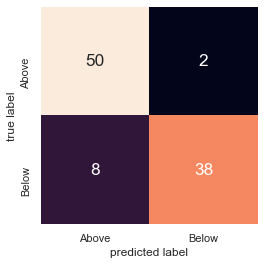

In [72]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [73]:
1 - clf.score(X_test, y_test)

0.10204081632653061

Employing logistic regression to predict mpg_med utilizing cylinders, displacement, horsepower, weight, year, and origin, resulted in an overall test error of 10.2%. This aligns closely with the test errors observed thus far with the other methods.

In [74]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 500))])

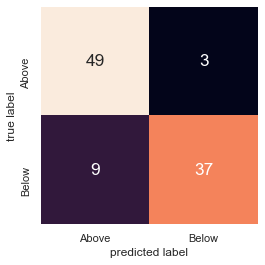

In [75]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [76]:
1 - clf.score(X_test, y_test)

0.12244897959183676

After exludding the origin and year variables, the test error increases, with two additional misclassified predictions, to 12.24%.

### (f) Perform KNN with several values of *K* on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained? Which value of *K* seems to perform the best on this data set?

In [77]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.081633
3     0.081633
5     0.081633
7     0.091837
9     0.091837
11    0.102041
13    0.081633
15    0.081633
17    0.081633
19    0.081633
dtype: float64

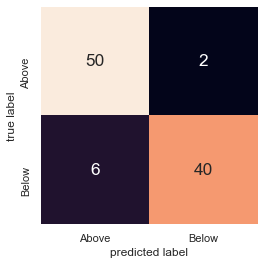

In [78]:
mat = confusion_matrices[pd.Series(knn_errors).idxmin()]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

Here, we find that when k=1, it yields the lowest test error at 8.16%, although k=3, 5, 13, 15, 17, and 19 all exhibit the same test error value. Upon inspecting the confusion matrix for k=1, stored in the dictionary confusion_matrices, we note that the majority of errors were false positives—cars classified by the model as having above-median fuel efficiency but actually belonging to the below-median group.

Next, I will proceed to exclude the year variable, as done in the previous parts, to assess how the test errors change.

In [79]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.112245
3     0.102041
5     0.112245
7     0.102041
9     0.091837
11    0.091837
13    0.091837
15    0.091837
17    0.091837
19    0.091837
dtype: float64

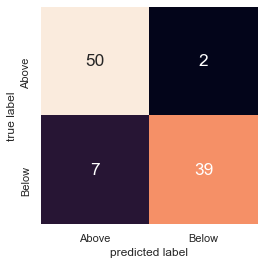

In [80]:
mat = confusion_matrices[pd.Series(knn_errors).idxmin()]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

Upon excluding the year variable, the model exhibited slightly poorer performance, particularly for lower values of k. Notably, the lowest test error occurred with k=9, where one additional false positive led to a test error of 9.18%.

In summary, utilizing k-nearest neighbors with k=1 and cylinders, displacement, horsepower, weight, and year as the predictors resulted in the lowest overall error on our held-out test set. However, it's crucial to exercise caution and gather more evidence by employing cross-validation to better assess the accuracy of this model.

***

# Question 16

### Using the `Boston` data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [81]:
boston_filepath = "https://raw.githubusercontent.com/namiyousef/ai_hack_2021/main/data/Boston_Housing_Market_Challenge/boston_fixed.csv"
index_cols = ["TOWN", "TRACT"]
data_cols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
            "PTRATIO", "B", "LSTAT"]
boston = pd.read_csv(boston_filepath, index_col = index_cols, usecols = data_cols)
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT  
TOWN      TRACT                                    
Arlington 3567     5  296     16.6  391.27   6.92  
          3566     5  296     16.6  395.60   6.29  
          3565     5  296     16.6  393.23  10.11  
          3564     5  296     16.6  390.96   5.33  
          3563     5  296     16.6  393.23   9.64

To start, we create a binary variable, `crim_med`, which is "Above" if `CRIM` contains a value above the median and "Below" otherwise.

In [82]:
crim_med = (boston["CRIM"] > boston["CRIM"].median()).map({False: "Below", True: "Above"})
boston["crim_med"] = crim_med
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT crim_med  
TOWN      TRACT                                             
Arlington 3567     5  296     16.6  391.27   6.92    Below  
          3566     5  296     16.6  395.60   6.29    Below  
          3565     5  296     16.6  393.23  10.11    Below  
          3564     5  296     16.6  390.96   5.33    Below  
          3563     5  296     16.6  393.23   9.64    Below

Next we explore the data both numerically, by looking at the matrix of correlations, and graphically, by looking at boxplots to investigate the association between `crim_med` and the other features. First, we look at the matrix of correlations.

In [83]:
boston.corr()["CRIM"]

CMEDV     -0.389582
CRIM       1.000000
ZN        -0.200469
INDUS      0.406583
CHAS      -0.055892
NOX        0.420972
RM        -0.219247
AGE        0.352734
DIS       -0.379670
RAD        0.625505
TAX        0.582764
PTRATIO    0.289946
B         -0.385064
LSTAT      0.455621
Name: CRIM, dtype: float64

We observe moderate to moderately strong correlations between the crime rate and the other variables. The most correlated variables are RAD (correlation of 0.626), which measures accessibility to radial highways, and TAX (correlation of 0.583), representing the property tax rate in USD per $10,000. In fact, all variables, except CHAS, an indicator variable with a value of 1 if a town borders the Charles River, have correlation values with a magnitude of at least 0.2. Additionally, as seen in Applied Exercise 8 from Chapter 3, each predictor, except CHAS, exhibited a statistically significant association with CRIM in univariate linear regressions.

Before deciding on predictors for fitting models, we will explore the data graphically through boxplots. We'll start by creating boxplots for each predictor, excluding CHAS, to compare suburbs with above-median crime rates and those with below-median crime rates.

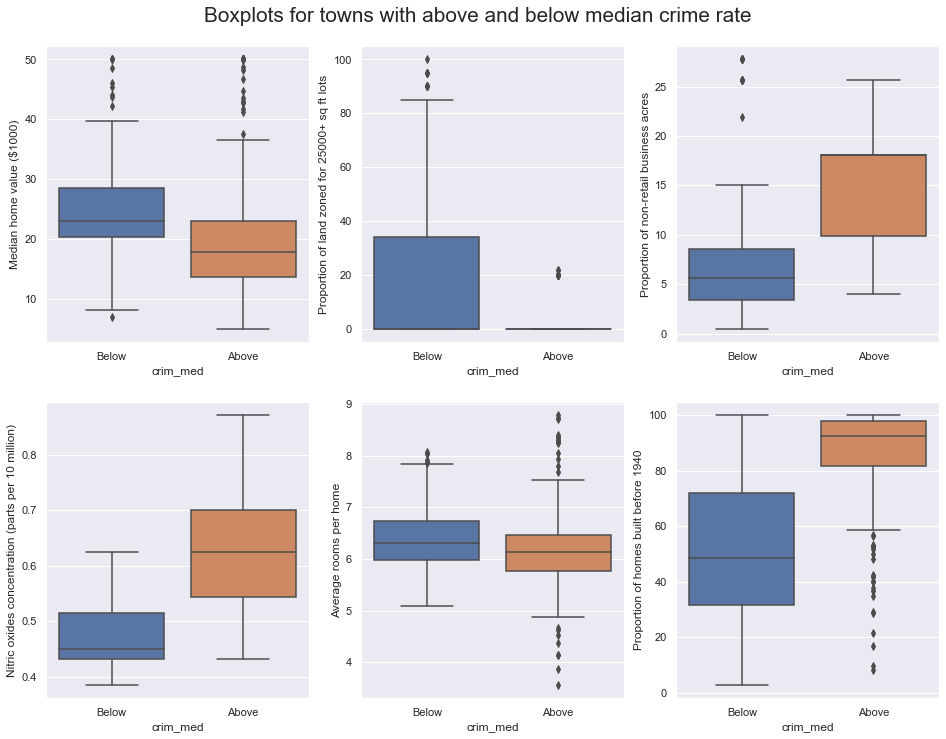

In [84]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "CMEDV", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Median home value ($1000)")
sns.boxplot(x = "crim_med", y = "ZN", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Proportion of land zoned for 25000+ sq ft lots")
sns.boxplot(x = "crim_med", y = "INDUS", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Proportion of non-retail business acres")
sns.boxplot(x = "crim_med", y = "NOX", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Nitric oxides concentration (parts per 10 million)")
sns.boxplot(x = "crim_med", y = "RM", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("Average rooms per home")
sns.boxplot(x = "crim_med", y = "AGE", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion of homes built before 1940")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

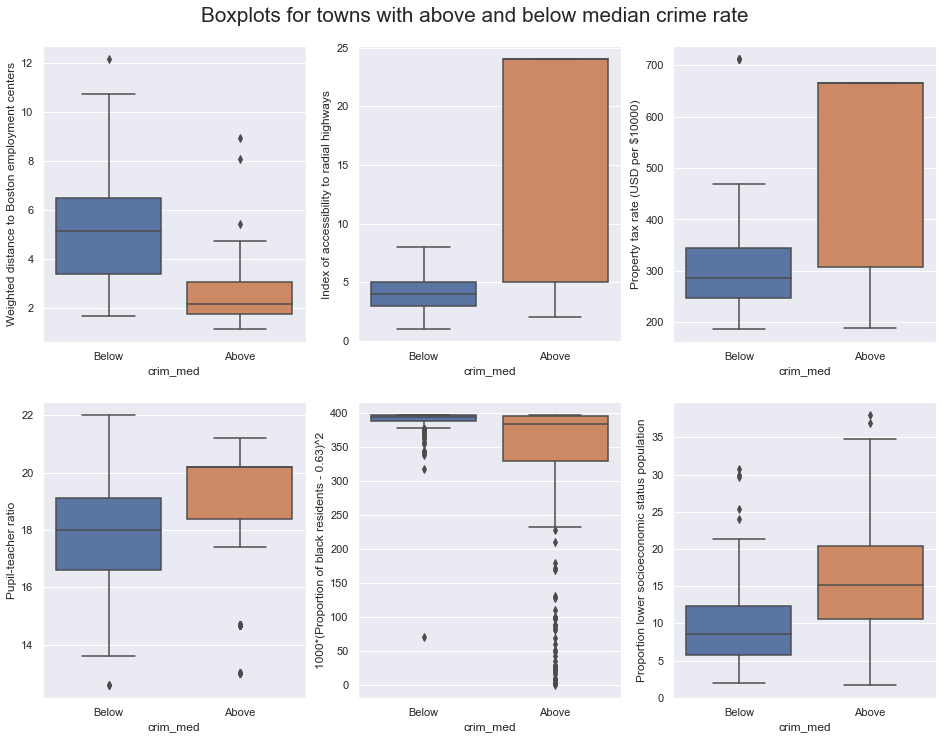

In [85]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "DIS", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Weighted distance to Boston employment centers")
sns.boxplot(x = "crim_med", y = "RAD", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Index of accessibility to radial highways")
sns.boxplot(x = "crim_med", y = "TAX", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Property tax rate (USD per $10000)")
sns.boxplot(x = "crim_med", y = "PTRATIO", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Pupil-teacher ratio")
sns.boxplot(x = "crim_med", y = "B", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("1000*(Proportion of black residents - 0.63)^2")
sns.boxplot(x = "crim_med", y = "LSTAT", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion lower socioeconomic status population")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

The twelve boxplots we generated provide further support for the notion that the most useful predictors in predicting crim_med are those with a correlation magnitude of at least 0.3 with CRIM (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT). These variables exhibit the most pronounced separation in distributions between suburbs with above-median crime rates and those with below-median crime rates. Specifically, for all these variables except CMEDV, the medians for suburbs with above-median crime rates are notably distinct from the upper or lower quartiles (depending on the variable) of values for suburbs with below-median crime rates.

Consequently, we will proceed by constructing models using two distinct subsets of predictors: one comprising all predictors except CHAS, and the other comprising only those predictors with at least a moderate correlation with CRIM (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT).

Prior to training any models, we will split our data into a training set and a test set using a 75%-25% split.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston["crim_med"], test_size = 0.25, random_state = 312)

We also make two arrays of columns to help with selecting the particular subsets of columns we wish to use: all of the predictors aside from `CHAS`, and those which are at least moderately correlated with `CRIM` (absolute value of correlation at least 0.3).

In [87]:
not_chas = boston.columns.drop(["CHAS", "CRIM", "crim_med"])
moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")

Now that we've divided the data into training and test sets, we proceed to fit classification models aimed at predicting whether a given suburb has an above-median crime rate. For the sake of simplicity, we'll adhere to the default prediction threshold of 50%. However, it's important to note that when making predictions for practical applications, it's advisable to consider other prediction thresholds based on the trade-off between false positives and false negatives.

In this analysis, we adopt the convention where an above-median crime rate is categorized as the positive class, while a below-median crime rate is categorized as the negative class. We'll begin by fitting the logistic regression model, initially using all predictors and then utilizing only the predictors that are moderately correlated with CRIM.

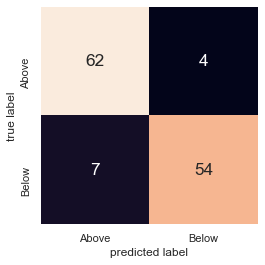

In [88]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [89]:
1 - clf.score(X_test[not_chas], y_test)

0.08661417322834641

When utilizing logistic regression to predict crim_med using all predictors except CHAS, we obtained an overall test error of 8.66%. Our positive predictive value was approximately 0.898, and our true positive rate was roughly 0.939. These results suggest a favorable error rate for our initial model. Now, let's proceed with the smaller subset of predictors and explore other models to assess if we can enhance performance further.

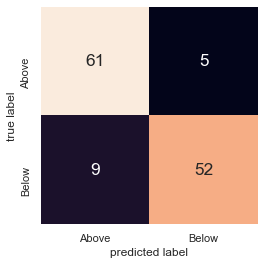

In [90]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [91]:
1 - clf.score(X_test[moderate_corr], y_test)

0.11023622047244097

The logistic regression model utilizing a reduced set of predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT) exhibited a slightly inferior performance, yielding an overall test error of 11.02%. It had a positive predictive value of approximately 0.871, which represents a slight decline compared to the model with more predictors. However, the true positive rate slightly improved to around 0.924.

The main source of error for the model with fewer predictors stems from misclassifying suburbs with below-median crime rates as belonging to the above-median category.

Next, we proceed to explore linear discriminant analysis.

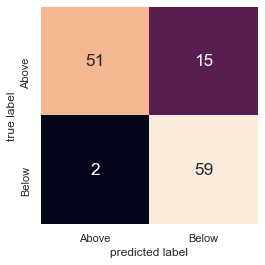

In [92]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [93]:
1 - clf.score(X_test[not_chas], y_test)

0.13385826771653542

In contrast to the logistic regression model using all predictors except CHAS, linear discriminant analysis (LDA) exhibited significantly poorer performance, yielding an overall test error of 13.4%. This represents almost double the overall test error observed with logistic regression. Such a substantial discrepancy in performance suggests that the assumption underlying LDA, wherein observations are drawn from a Gaussian distribution and both classes share a common covariance matrix, is not met for at least some of these predictors.

The primary source of error in the LDA model arises from misclassifying suburbs with above-median crime rates as belonging to the below-median category. This underscores the limitations of LDA in accurately modeling the underlying data distribution in this context.

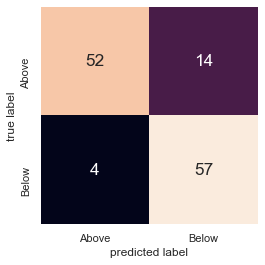

In [94]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [95]:
1 - clf.score(X_test[moderate_corr], y_test)

0.1417322834645669

Similar to the model utilizing all predictors except CHAS, linear discriminant analysis (LDA) with a reduced set of predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT) performed worse than the logistic regression model using the same predictors. However, it did exhibit slightly improved performance compared to the LDA model with more predictors. Thus far, logistic regression seems to offer the most favorable test error rate.

Next, we proceed to explore quadratic discriminant analysis (QDA).

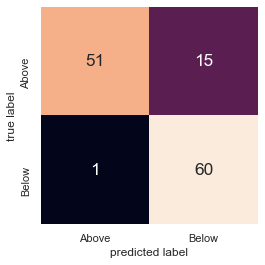

In [96]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [97]:
1 - clf.score(X_test[not_chas], y_test)

0.12598425196850394

Quadratic discriminant analysis (QDA) using all predictors except CHAS yielded an overall test error rate of 12.5%, comparable to that of logistic regression utilizing the subset of predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT). This marks a notable improvement over linear discriminant analysis (LDA) with the same predictors, suggesting that relaxing the assumption of a common covariance matrix for both classes in QDA to assuming each class has its own covariance matrix is a more accurate representation of the data.

Notably, the QDA model exhibited a high positive predictive value of approximately 0.981, the highest value among all models evaluated thus far. This implies that the QDA model is particularly effective in minimizing the number of suburbs with below-median crime rates that are incorrectly predicted to be in the above-median category.

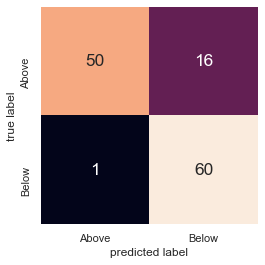

In [98]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [99]:
1 - clf.score(X_test[moderate_corr], y_test)

0.13385826771653542

Using the reduced subset of predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT) led to a QDA model with a slightly higher overall test error rate of 13.4% compared to the QDA model with more predictors. Nevertheless, this QDA model still exhibits a superior overall test error rate compared to both LDA models.

Next, we will proceed with k-nearest neighbors classification. To ensure consistency, we will standardize all variables to have mean zero and standard deviation one using a pipeline with the StandardScaler, similar to our approach in part (g) of Question 2 above.

In [100]:
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[not_chas], y_train)
    y_pred = clf.predict(X_test[not_chas])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[not_chas], y_test)
pd.Series(knn_errors)

1     0.062992
3     0.070866
5     0.070866
7     0.062992
9     0.062992
11    0.086614
13    0.094488
15    0.110236
17    0.141732
19    0.173228
dtype: float64

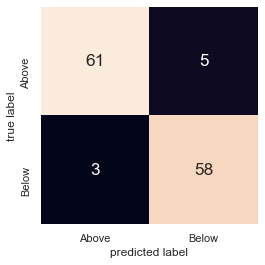

In [101]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

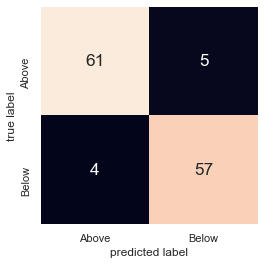

In [102]:
mat = confusion_matrices[3]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [103]:
61/66

0.9242424242424242

When employing all predictors except CHAS, the values of k yielding the lowest overall test error for k-nearest neighbors classification are k=1 and k=3, both resulting in an overall test error of 6.3%. This signifies a reduction of two misclassified test observations compared to logistic regression using the same predictors, thereby offering the most favorable overall test error rate among the explored model and predictor combinations.

Reviewing the confusion matrix, we note that k-nearest neighbors classification with k=3 achieves the highest positive predictive value among all classification models, approximately 0.938. Moreover, in comparison to logistic regression using the same predictors, this model demonstrates an identical true positive rate, approximately 0.924.

In [104]:
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[moderate_corr], y_train)
    y_pred = clf.predict(X_test[moderate_corr])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[moderate_corr], y_test)
pd.Series(knn_errors)

1     0.078740
3     0.086614
5     0.070866
7     0.086614
9     0.102362
11    0.118110
13    0.125984
15    0.125984
17    0.133858
19    0.133858
dtype: float64

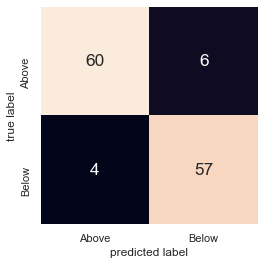

In [105]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

When focusing on the smaller subset of predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT), we once again find that k=1 yields the lowest overall test error rate. However, with this reduced set of predictors, the KNN model using k=1 exhibits a slightly diminished performance compared to the previous KNN classifier with more predictors. An examination of the confusion matrix reveals that the additional errors arise predominantly from false positives.

While further assessments, such as cross-validation, are necessary to confidently determine the preferred model based on specific evaluation metrics, it seems that two models stand out: logistic regression using all predictors except CHAS, and k-nearest neighbors with k=3 using the same set of predictors. Logistic regression offers simplicity and interpretability, boasting the second lowest overall test error among the explored models. Conversely, the KNN classifier demonstrates marginally lower overall test error and notably superior positive predictive value compared to logistic regression, particularly when logistic regression adopts a prediction threshold of 0.5. To provide a more comprehensive comparison between these models, generating ROC curves for each and assessing their area-under-curve values would be beneficial.